In [2]:
# Step 0: imports and load
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

# load the data (sheet name 'glass')
file_path = "/content/glass.xlsx"
xls = pd.ExcelFile(file_path)
df = xls.parse("glass")

# quick peek
print("Shape:", df.shape)
display(df.head())


Shape: (214, 10)


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [3]:
# 1.1 Summary stats, dtypes, missing values, duplicates
print(df.info())
print("\nMissing values per column:\n", df.isna().sum())
print("\nDuplicate rows:", df.duplicated().sum())

# 1.2 Numeric summary
display(df.describe().transpose())

# 1.3 Class distribution (target = 'Type')
print("\nClass distribution:")
print(df['Type'].value_counts().sort_index())

# 1.4 Simple outlier detection (IQR method) — flag counts per feature
def iqr_outlier_counts(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return ((series < lower) | (series > upper)).sum()

outlier_summary = {col: iqr_outlier_counts(df[col]) for col in df.columns if col != 'Type'}
print("\nOutliers (IQR counts) per feature:\n", outlier_summary)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   Type    214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 16.8 KB
None

Missing values per column:
 RI      0
Na      0
Mg      0
Al      0
Si      0
K       0
Ca      0
Ba      0
Fe      0
Type    0
dtype: int64

Duplicate rows: 1


,count,mean,std,min,25%,50%,75%,max
RI,214.0,1.518365,0.003037,1.51115,1.516522,1.51768,1.519157,1.53393
Na,214.0,13.407850,0.816604,10.73000,12.907500,13.30000,13.825000,17.38000
Mg,214.0,2.684533,1.442408,0.00000,2.115000,3.48000,3.600000,4.49000
Al,214.0,1.444907,0.499270,0.29000,1.190000,1.36000,1.630000,3.50000
Si,214.0,72.650935,0.774546,69.81000,72.280000,72.79000,73.087500,75.41000
K,214.0,0.497056,0.652192,0.00000,0.122500,0.55500,0.610000,6.21000
Ca,214.0,8.956963,1.423153,5.43000,8.240000,8.60000,9.172500,16.19000
Ba,214.0,0.175047,0.497219,0.00000,0.000000,0.00000,0.000000,3.15000
Fe,214.0,0.057009,0.097439,0.00000,0.000000,0.00000,0.100000,0.51000
Type,214.0,2.780374,2.103739,1.00000,1.000000,2.00000,3.000000,7.00000



Class distribution:
Type
1    70
2    76
3    17
5    13
6     9
7    29
Name: count, dtype: int64

Outliers (IQR counts) per feature:
 {'RI': np.int64(17), 'Na': np.int64(7), 'Mg': np.int64(0), 'Al': np.int64(18), 'Si': np.int64(12), 'K': np.int64(7), 'Ca': np.int64(26), 'Ba': np.int64(38), 'Fe': np.int64(12)}


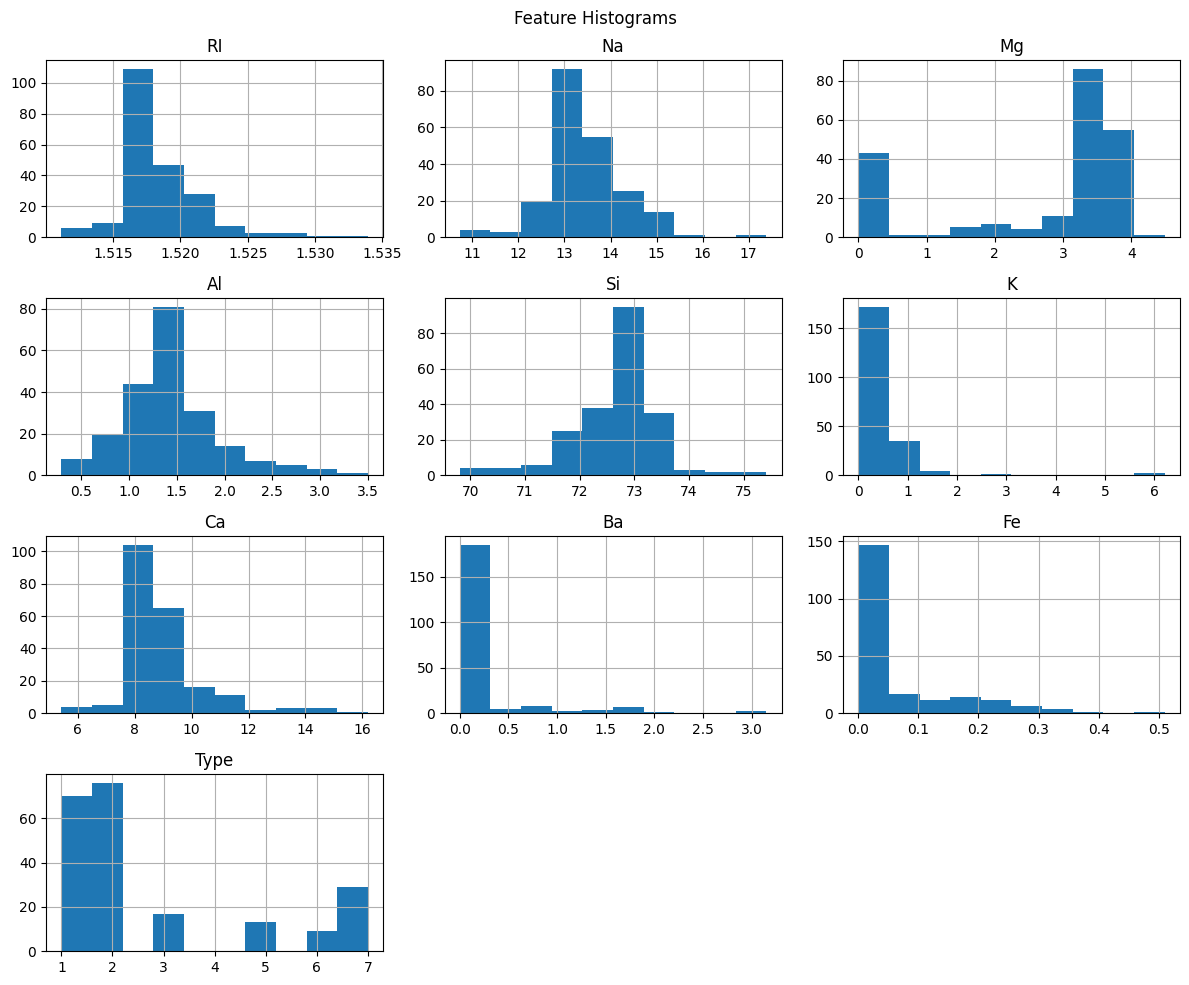

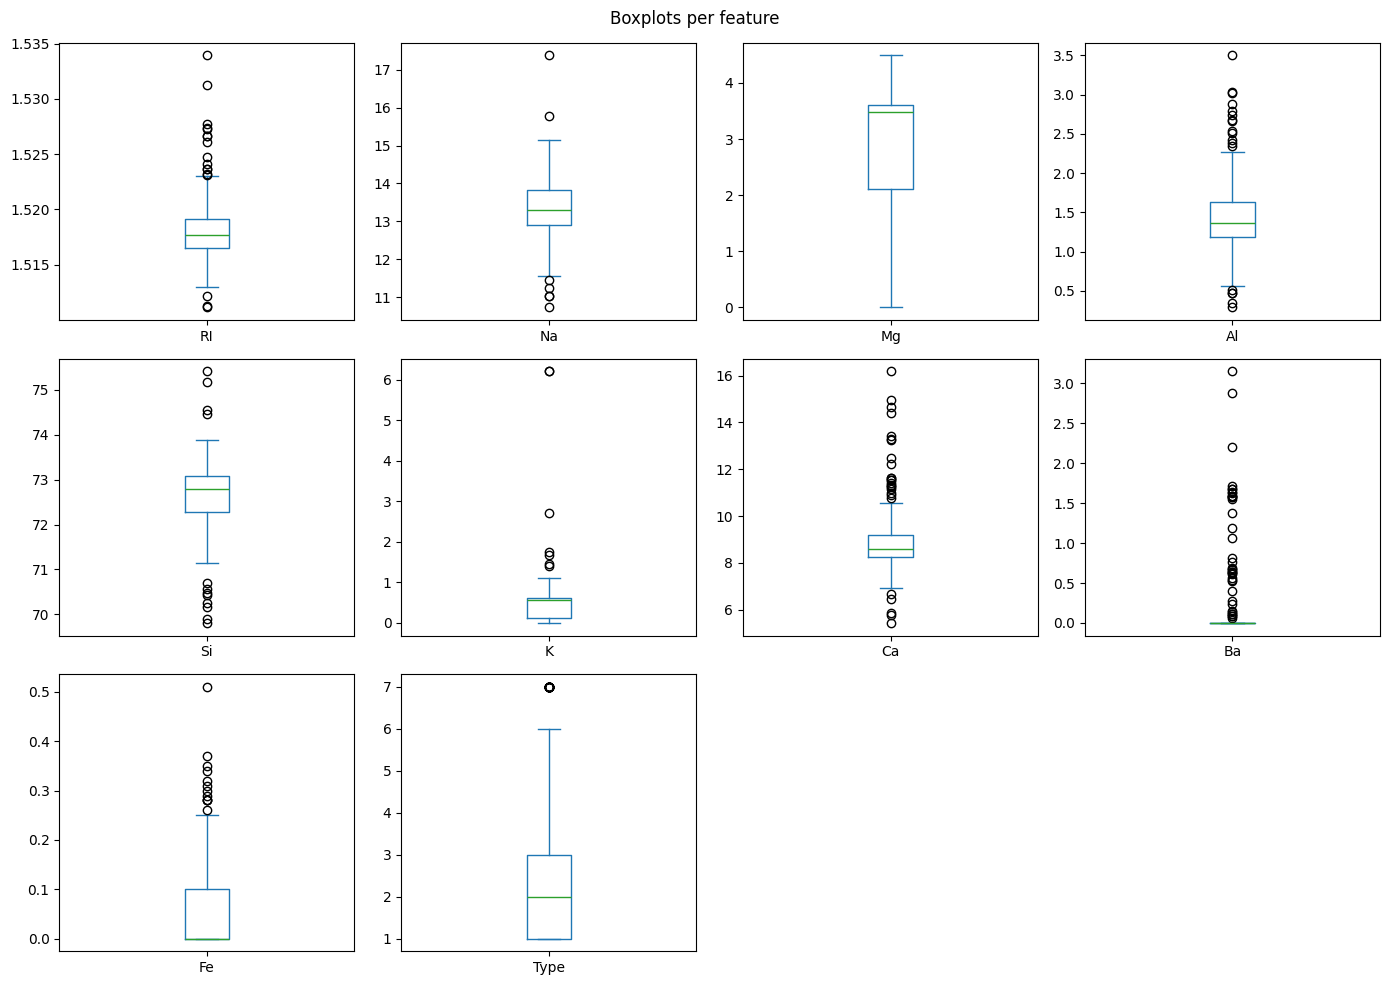

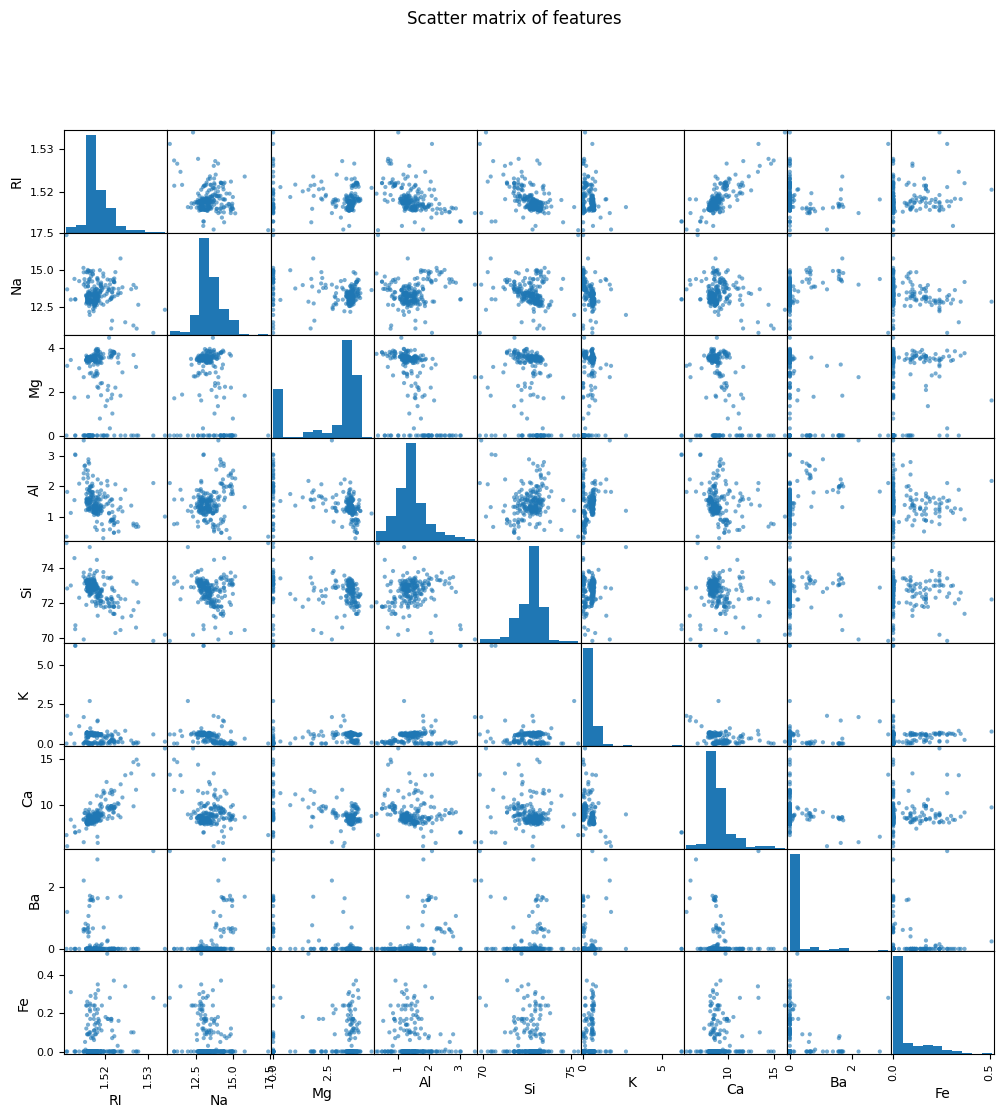

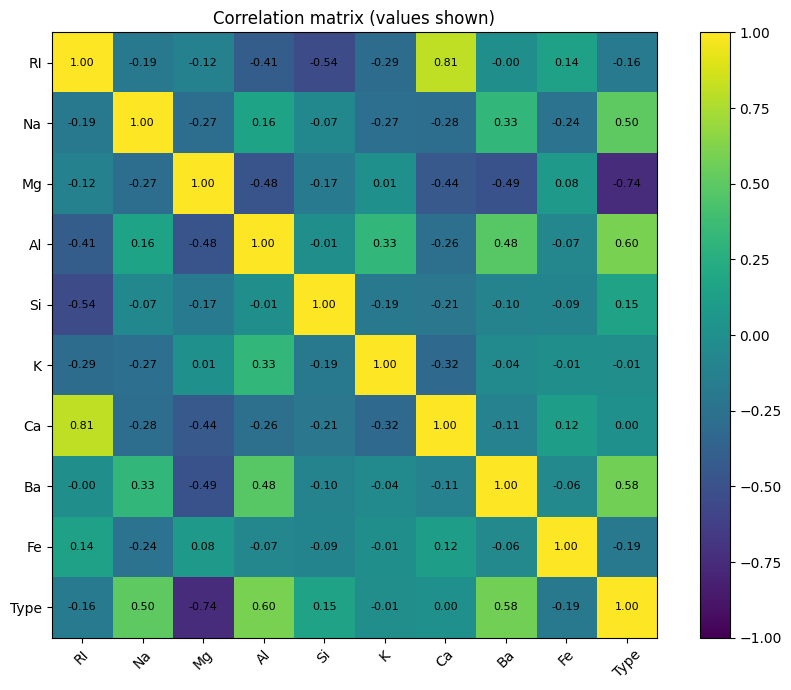

In [4]:
# 2.1 Histograms
df.hist(figsize=(12,10))
plt.suptitle("Feature Histograms")
plt.tight_layout()
plt.show()

# 2.2 Boxplots (to visualize the outliers)
df.plot(kind='box', subplots=True, layout=(3,4), figsize=(14,10), sharex=False, sharey=False)
plt.suptitle("Boxplots per feature")
plt.tight_layout()
plt.show()

# 2.3 Pairwise scatter matrix (pair-plot style)
scatter_matrix(df.iloc[:, :-1], alpha=0.6, diagonal='hist', figsize=(12,12))
plt.suptitle("Scatter matrix of features")
plt.show()

# 2.4 Correlation heatmap (matplotlib)
corr = df.corr()
plt.figure(figsize=(9,7))
plt.imshow(corr, interpolation='nearest', vmin=-1, vmax=1)
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45)
plt.yticks(range(len(corr.columns)), corr.columns)
for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        plt.text(j, i, f"{corr.iloc[i,j]:.2f}", ha='center', va='center', fontsize=8)
plt.title("Correlation matrix (values shown)")
plt.tight_layout()
plt.show()


In [5]:
#Missing Values
# Check again and handle if present
miss = df.isna().sum()
print("Missing per column:\n", miss)

# If missing exists, we impute numeric features with mean:
if miss.sum() > 0:
    imputer = SimpleImputer(strategy='mean')
    df[df.columns[:-1]] = imputer.fit_transform(df[df.columns[:-1]])
    print("Applied mean imputation to numeric columns.")
else:
    print("No missing values found.")


Missing per column:
 RI      0
Na      0
Mg      0
Al      0
Si      0
K       0
Ca      0
Ba      0
Fe      0
Type    0
dtype: int64
No missing values found.


In [6]:
#Feature Scaling
# Prepare X,y
X = df.drop(columns=['Type']).values
y = df['Type'].values

# Stratified split (keeps class proportions)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (171, 9) Test shape: (43, 9)


In [7]:
#Handling Class Imbalance
# examine class balance in training set
import collections
print("Train class counts:", collections.Counter(y_train))

# OPTION A (preferred when imbalance is moderate): use SMOTE on training data
# Requires imblearn
try:
    from imblearn.over_sampling import SMOTE
    smote = SMOTE(random_state=42)
    X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)
    print("After SMOTE, train class counts:", collections.Counter(y_train_bal))
except Exception as e:
    print("imblearn not available or error:", e)
    print("You can pip install imblearn: pip install -U imbalanced-learn")
    # fallback: use original training data
    X_train_bal, y_train_bal = X_train_scaled, y_train


Train class counts: Counter({np.int64(2): 61, np.int64(1): 56, np.int64(7): 23, np.int64(3): 14, np.int64(5): 10, np.int64(6): 7})
After SMOTE, train class counts: Counter({np.int64(7): 61, np.int64(1): 61, np.int64(2): 61, np.int64(3): 61, np.int64(6): 61, np.int64(5): 61})



=== RandomForestClassifier ===
Accuracy: 0.7441860465116279
Precision (macro): 0.7593795093795093
Recall (macro): 0.8126984126984126
F1-score (macro): 0.7646185997910137

Classification Report:
               precision    recall  f1-score   support

           1       0.82      0.64      0.72        14
           2       0.79      0.73      0.76        15
           3       0.29      0.67      0.40         3
           5       1.00      1.00      1.00         3
           6       0.67      1.00      0.80         2
           7       1.00      0.83      0.91         6

    accuracy                           0.74        43
   macro avg       0.76      0.81      0.76        43
weighted avg       0.80      0.74      0.76        43

Confusion Matrix:
 [[ 9  2  3  0  0  0]
 [ 1 11  2  0  1  0]
 [ 1  0  2  0  0  0]
 [ 0  0  0  3  0  0]
 [ 0  0  0  0  2  0]
 [ 0  1  0  0  0  5]]

RandomForest 5-fold CV accuracy scores: [0.76744186 0.76744186 0.69767442 0.8372093  0.78571429]
Mean CV accuracy:

,0
Mg,0.182903
Na,0.133600
K,0.132978
Ca,0.128650
RI,0.115173
Al,0.108560
Ba,0.097571
Si,0.080514
Fe,0.020052


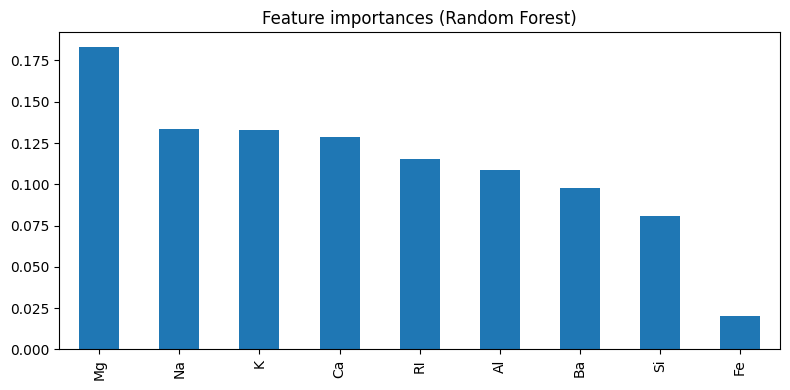

In [8]:
#Random Forest Model implementation
# Helper eval function
def evaluate(clf, X_tr, y_tr, X_te, y_te):
    clf.fit(X_tr, y_tr)
    y_pred = clf.predict(X_te)
    acc = accuracy_score(y_te, y_pred)
    prec = precision_score(y_te, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_te, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_te, y_pred, average='macro', zero_division=0)
    print(f"\n=== {clf.__class__.__name__} ===")
    print("Accuracy:", acc)
    print("Precision (macro):", prec)
    print("Recall (macro):", rec)
    print("F1-score (macro):", f1)
    print("\nClassification Report:\n", classification_report(y_te, y_pred, zero_division=0))
    print("Confusion Matrix:\n", confusion_matrix(y_te, y_pred))
    return {"acc":acc, "prec":prec, "rec":rec, "f1":f1, "clf":clf}

# Train Random Forest (use balanced class weight if you did not apply SMOTE)
rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight=None)
# If you used class-weight strategy:
# rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')

# Evaluate using SMOTE-resampled training if available:
res_rf = evaluate(rf, X_train_bal, y_train_bal, X_test_scaled, y_test)

# Cross-validation (5-fold stratified) for a robust accuracy estimate
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(RandomForestClassifier(n_estimators=200, random_state=42),
                            scaler.transform(X), y, cv=cv, scoring='accuracy')
print("\nRandomForest 5-fold CV accuracy scores:", cv_scores)
print("Mean CV accuracy:", cv_scores.mean())

# Feature importances
feat_names = df.columns[:-1]
imp = pd.Series(res_rf['clf'].feature_importances_, index=feat_names).sort_values(ascending=False)
display(imp)
imp.plot(kind='bar', figsize=(8,4))
plt.title("Feature importances (Random Forest)")
plt.tight_layout()
plt.show()


In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

# Bagging with DecisionTree base
bag = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=100,
    random_state=42
)
results.append(("Bagging (DT)", evaluate(bag, X_train_bal, y_train_bal, X_test_scaled, y_test)))



=== BaggingClassifier ===
Accuracy: 0.7209302325581395
Precision (macro): 0.7503968253968254
Recall (macro): 0.8007936507936507
F1-score (macro): 0.7496691048415186

Classification Report:
               precision    recall  f1-score   support

           1       0.80      0.57      0.67        14
           2       0.79      0.73      0.76        15
           3       0.25      0.67      0.36         3
           5       1.00      1.00      1.00         3
           6       0.67      1.00      0.80         2
           7       1.00      0.83      0.91         6

    accuracy                           0.72        43
   macro avg       0.75      0.80      0.75        43
weighted avg       0.79      0.72      0.74        43

Confusion Matrix:
 [[ 8  2  4  0  0  0]
 [ 1 11  2  0  1  0]
 [ 1  0  2  0  0  0]
 [ 0  0  0  3  0  0]
 [ 0  0  0  0  2  0]
 [ 0  1  0  0  0  5]]
